first we use the tensorflow version 2

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.5.0


Now we use the data generator of tensorflow to generate some data and prepare our time series data for our Model.



```
tf.data.Dataset.range(10)
```



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
dataset = tf.data.Dataset.range(10)
for data in dataset:
    print(data.numpy())

0
1
2
3
4
5
6
7
8
9


Now we want to create some windows of our data.



```
dataset.window(size=5, shift=1, stride=1, drop_remainder=False)
```



In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(size=5, shift=1, stride=1, drop_remainder=False)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


For Having the same size of window we need to put 



```
drop_remainder = True
```



In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(size=5, shift=1, stride=1, drop_remainder=True)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


After creating the window of data we need to using flat_map to achieve the window created.



```
dataset.flat_map(lambda window: window.batch(5))
```



In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, 1, 1, True)
dataset = dataset.flat_map(map_func=lambda window:window.batch(5))
for window in dataset:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


Then we need to create our label by extracting the last index of series as labels of our model

In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, 1, 1, True)
dataset = dataset.flat_map(map_func=lambda window:window.batch(5))
dataset = dataset.map(map_func=lambda window: (window[:-1], window[-1:]))
for x, y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


Now for avoiding sequense biasing of data we need to shuffle our dataset
then we create batch size = 2 of our data

In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(size=5, shift=1, stride=1, drop_remainder=True)
dataset = dataset.flat_map(map_func=lambda window: window.batch(5))
dataset = dataset.map(map_func=lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)

for x, y in dataset:
    print('x=', x.numpy())
    print('y=', y.numpy())

x= [[5 6 7 8]
 [0 1 2 3]]
y= [[9]
 [4]]
x= [[4 5 6 7]
 [1 2 3 4]]
y= [[8]
 [5]]
x= [[3 4 5 6]
 [2 3 4 5]]
y= [[7]
 [6]]


It's time to work our generated data and create a model to forecast our time series data.

In [ ]:
#@title Generate The Data and split into train and validation
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(size=window_size + 1, shift=1, stride=1, drop_remainder=True)
    dataset = dataset.flat_map(map_func=lambda window: window.batch(window_size + 1))
    dataset = dataset.map(map_func=lambda window:(window[:-1], window[-1:]))
    dataset = dataset.shuffle(buffer_size=shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.float32, tf.float32)>


In [ ]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)

print('Layer weights {}'.format(l0.get_weights()))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Layer weights [array([[-0.08986802],
       [ 0.02327801],
       [ 0.12270292],
       [-0.06339618],
       [-0.03396026],
       [ 0.03964241],
       [ 0.03498304],
       [-0.01807835],
       [-0.09265522],
       [ 0.09794816],
       [ 0.01480406],
       [ 0.01055175],
       [-0.09405089],
       [ 0.01369604],
       [-0.00911184],
       [ 0.10481604],
       [ 0.1287465 ],
       [ 0.10204071],
       [ 0.25715366],
       [ 0.44080663]], dtype=float32), array([0.02055641], dtype=float32)]


In [ ]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]

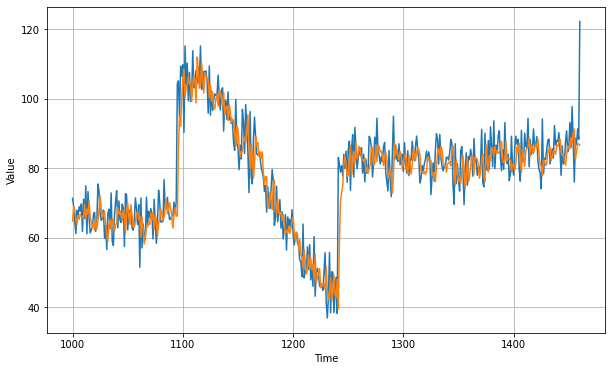

In [ ]:
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.103941

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


(1e-08, 0.001, 0.0, 300.0)

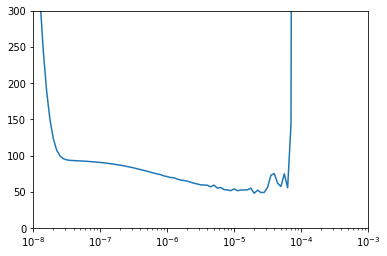

In [ ]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [ ]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


[51.72939682006836, 55.84638214111328, 56.91757583618164, 52.306800842285156, 50.24855422973633, 47.486629486083984, 49.46355438232422, 47.11478042602539, 51.67547607421875, 48.38674545288086, 46.73685836791992, 47.140380859375, 47.04862976074219, 47.648738861083984, 44.711669921875, 45.31531524658203, 44.21002960205078, 47.53627014160156, 43.75876235961914, 44.56010055541992, 43.404850006103516, 42.90605163574219, 42.85690689086914, 48.62153244018555, 46.5079345703125, 43.618858337402344, 44.23630142211914, 41.83147430419922, 45.05619812011719, 41.72591018676758, 43.43838119506836, 43.25422286987305, 44.282596588134766, 41.361881256103516, 42.94757080078125, 42.26929473876953, 43.95109558105469, 40.5804557800293, 41.64180374145508, 41.41536331176758, 41.707149505615234, 44.95908737182617, 40.63474655151367, 40.32471466064453, 40.364322662353516, 40.740943908691406, 41.288818359375, 42.25405502319336, 42.68854522705078, 40.73276138305664, 39.60560989379883, 40.02769470214844, 39.055725

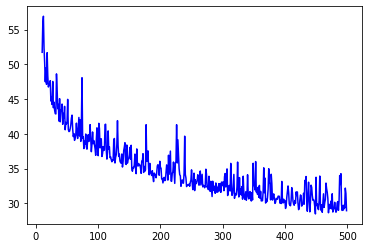

In [ ]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.103941